# Grating efficiency benchmark

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FGratingEfficiency.ipynb).

In this example, we compute the grating efficiency of a multilevel diffraction grating whose design is inspired by the work of Oliva et al. (2011), which is linked [here](https://opg.optica.org/oe/fulltext.cfm?uri=oe-19-15-14735&id=220358).

Tidy3D uses a two-dimensional fast Fourier transform (FFT) to compute the grating efficiency, and its accuracy is verified through a comparison with the semi-analytical rigorous coupled wave analysis (RCWA) approach, using the open-source library [grcwa](https://grcwa.readthedocs.io/en/latest/index.html).

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3D import
import tidy3d as td
from tidy3d import web

[17:36:02] INFO     Using client version: 1.7.0                                ]8;id=639961;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py\__init__.py]8;;\:]8;id=739771;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py#95\95]8;;\

## Geometry setup
First, the structure and simulation geometry are defined. The structure includes a dielectric substrate with two dielectric patterned layers.

In [2]:
# Grating parameters (all lengths in um)
index = 1.46847
period = 1.866
width_layer1 = 0.519
width_layer2 = 1.202
height_layer1 = 0.333
height_layer2 = 0.281

# free space central wavelength
wavelength = 0.416

# Simulation domain geometry
space_above = wavelength * 3
height_substrate = wavelength * 3
space_below = wavelength * 3

# Define a buffer to make sure objects extend past the simulation boundary
buffer = 0.1

# Simulation size
length_x = period
length_y = 0.2 # make it thin because it's translationally invariant along y
length_z = space_below + height_substrate + height_layer1 + height_layer2 + space_above
sim_size = (length_x, length_y, length_z)

# Define the medium
grating_medium = td.Medium(permittivity=index**2)

# Create the substrate
substrate = td.Structure(
    geometry=td.Box(
        center=[0, 0, -length_z / 2 + height_substrate / 2 + space_below],
        size=[td.inf, td.inf, height_substrate]
    ),
    medium=grating_medium
)

# Level 1 grating
center_L1 = [
    -buffer / 2 - length_x / 2 + width_layer1 / 2 + width_layer2 / 2,
    0,
    -length_z / 2 + space_below + height_substrate + height_layer2 / 2,
]
size_L1 = [width_layer1 + width_layer2 + buffer, td.inf, height_layer2]
grating_L1 = td.Structure(
    geometry=td.Box(center=center_L1, size=size_L1),
    medium=grating_medium,
)

# Level 2 grating
center_L2 = [
    -buffer / 2 - length_x / 2 + width_layer1 / 2,
     0,
     -length_z / 2 + space_below + height_substrate + height_layer2 + height_layer1 / 2,
]
size_L2 = [width_layer1 + buffer, td.inf, height_layer1]
grating_L2 = td.Structure(
    geometry=td.Box(center=center_L2, size=size_L2),
    medium=grating_medium,
)

# Collect all structures
structures = [substrate, grating_L1, grating_L2]

## Source setup
Next, define the source plane wave impinging from above the grating at an angle.

In [3]:
# Central frequency in Hz
f0 = td.C_0 / wavelength

# Bandwidth
fwidth = f0 / 40.0

# Run time
run_time = 100 / fwidth

# Time dependence of source
gaussian = td.GaussianPulse(freq0=f0, fwidth=fwidth)

# Source
src_z = length_z / 2 - space_above / 2
angle_theta = np.pi/10*0
source = td.PlaneWave(
            center=(0, 0, src_z),
            size=(td.inf, td.inf, 0),
            source_time=gaussian,
            direction='-',
            pol_angle=np.pi/2*0,
            angle_theta=angle_theta,
            angle_phi=0
)

## Monitor setup
Here, we'll set up a field monitor to record and plot the frequency domain fields at a plane in the `xz` cross-section. Also, we'll set up two `DiffractionMonitor`s, one for reflection, and the other for transmission.

In [4]:
# Fields
monitor_xz = td.FieldMonitor(
    center=[0, 0, 0],
    size=[td.inf, 0, td.inf],
    freqs=[f0],
    name='field_xz'
)

# We'll request all orders up to 20, but only those within the light cone
# will be returned in the final results.
orders = list(range(-20, 21))
monitor_r = td.DiffractionMonitor(
    center=[0., 0., length_z / 2 - wavelength],
    size=[td.inf, td.inf, 0],
    freqs=[f0],
    name='reflection',
    orders_x = orders,
    orders_y = orders,
    normal_dir='+',
)

monitor_t = td.DiffractionMonitor(
    center=[0., 0., -length_z / 2 + wavelength],
    size=[td.inf, td.inf, 0],
    freqs=[f0],
    name='transmission',
    orders_x = orders,
    orders_y = orders,
    normal_dir='-',
)

monitors = [monitor_xz, monitor_r, monitor_t]

## Set up boundary conditions and the simulation object
Bloch boundary conditions are applied along the `x` and `y` directions, to support the angled-incidence plane wave. The Bloch vector is automatically computed based on the plane wave parameters, as shown below. Along `z`, a perfectly matched layer (PML) is applied to mimic an infinite domain along `z`.

In [5]:
# Boundaries
bloch_x = td.Boundary.bloch_from_source(source=source, domain_size=sim_size[0], axis=0)
bloch_y = td.Boundary.bloch_from_source(source=source, domain_size=sim_size[1], axis=1)
boundary_spec = td.BoundarySpec(
    x=bloch_x,
    y=bloch_y,
    z=td.Boundary(minus=td.PML(), plus=td.PML())
)

# Simulation
simulation = td.Simulation(
    size=sim_size,
    grid_spec = td.GridSpec.auto(min_steps_per_wvl=40),
    structures=structures,
    sources=[source],
    monitors=monitors,
    run_time=run_time,
    boundary_spec=boundary_spec
)

## Visualize the simulation setup
Make sure everything is set up correctly by plotting the geometry.

           INFO     Auto meshing using wavelength 0.4160 defined from        ]8;id=50302;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=343310;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#473\473]8;;\
                    sources.                                                                 

<Figure size 1080x576 with 3 Axes>

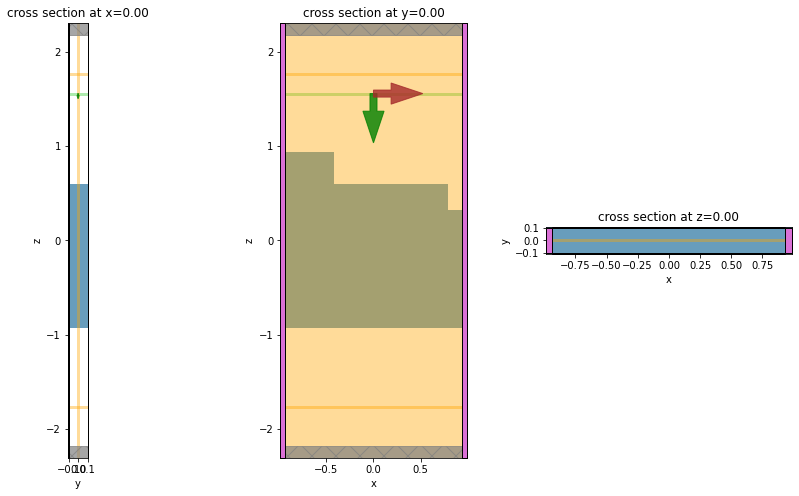

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))
simulation.plot(x=0, ax=axs[0]);
simulation.plot(y=0, ax=axs[1]);
simulation.plot(z=0, ax=axs[2]);
plt.show()

## Run simulation

In [7]:
import tidy3d.web as web
sim_data = web.run(simulation, task_name='GratingEfficiency', path='data/GratingEfficiency.hdf5')

[17:36:03] INFO     Using client version: 1.7.0                   __init__.py:95
           INFO     Auto meshing using wavelength 0.4160        grid_spec.py:473
                    defined from sources.                                       
 1 nodes: total GB 184.04697; MB per time step 0.39730 
[22-09-28 17:36:03][SUPPORT]: Max device memory required (GB): 0.404768
[22-09-28 17:36:03][SUPPORT]: Estimated solver time (Am): 8.537757
[17:36:04] INFO     Using client version: 1.7.0                   __init__.py:95
[22-09-28 17:36:04][USER   ]: Simulation domain Nx, Ny, Nz: [265, 29, 531]
[22-09-28 17:36:04][USER   ]: Applied symmetries: (0, 0, 0)
[22-09-28 17:36:04][USER   ]: Number of computational grid points: 4.4116e+06.
[22-09-28 17:36:04][USER   ]: Using subpixel averaging: True
[22-09-28 17:36:04][USER   ]: Number of time steps: 4.6325e+05
[22-09-28 17:36:04][USER   ]: Automatic shutoff factor: 1.00e-05
[22-09-28 17:36:04][USER   ]: Time step (s): 1.1982e-17

[22-09-28 17:36:04][U

Invalid MIT-MAGIC-COOKIE-1 key

Initializing the MPI...
Wed Sep 28 17:36:08 2022, rank 0: Initialized MPI!
[17:36:08] INFO     Using client version: 1.7.0                   ]8;id=901343;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py\__init__.py]8;;\:]8;id=170069;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py#95\95]8;;\
[22-09-28 17:36:09][SUPPORT]: Simulation setup starting on rank 0.
[22-09-28 17:36:09][SUPPORT]: Computational domain size Nx, Ny, Nz: [267, 31, 533]
[22-09-28 17:36:09][SUPPORT]: Simulation split in [1, 1, 1] chunks.
[22-09-28 17:36:09][SUPPORT]: Setting up source index 0 on rank 0.
[22-09-28 17:36:09][SUPPORT]: Setting up monitor index 0 on rank 0.
[22-09-28 17:36:09][SUPPORT]: Setting up monitor index 1 on rank 0.
[22-09-28 17:36:09][SUPPORT]: Setting up monitor index 2 on rank 0.
[22-09-28 17:36:09][SUPPORT]: Setup chunk time 0.1973 on rank 0.
Wed Sep 28 17:36:09 2022, rank 0: Rest of setup time (s

## Diffraction data
Now we can extract the diffracted power from the output data structures and verfify that the sum across all reflection and transmission orders is close to 1. We can also access the diffraction angles and the complex power amplitudes for each order and polarization.

In [8]:
data_r = sim_data["reflection"]
data_t = sim_data["transmission"]
print(f"Total power: {sum(sum(data_r.power.values + data_t.power.values))}")
print(f"\nTheta angles (degrees): \n{data_t.angles[0] * 180 / np.pi}")
print(f"\nAmplitude data: \n{data_t.amps}")

[17:53:11] INFO     Auto meshing using wavelength 0.4160 defined from        ]8;id=436906;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=429199;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#473\473]8;;\
                    sources.                                                                 

Total power: [0.9965855]

Theta angles (degrees): 
<xarray.DataArray (orders_x: 9, orders_y: 1, f: 1)>
array([[[63.09360835]],

       [[41.97530865]],

       [[26.47924028]],

       [[12.88158202]],

       [[ 0.        ]],

       [[12.88158202]],

       [[26.47924028]],

       [[41.97530865]],

       [[63.09360835]]])
Coordinates:
  * orders_x  (orders_x) int64 -4 -3 -2 -1 0 1 2 3 4
  * orders_y  (orders_y) int64 0
  * f         (f) float64 7.207e+14

Amplitude data: 
<xarray.DiffractionDataArray (orders_x: 9, orders_y: 1, polarization: 2, f: 1)>
array([[[[ 5.35689345e-18-1.12022750e-17j],
         [ 3.26598147e-02-6.88663002e-02j]]],


       [[[-1.27904930e-17+7.61416061e-18j],
         [-1.00129220e-01+5.96344379e-02j]]],


       [[[ 3.77844374e-17-1.95011810e-17j],
         [ 3.06685997e-01-1.58262722e-01j]]],


       [[[ 3.47209218e-17+5.13190729e-17j],
         [ 2.83434361e-01+4.18931092e-01j]]],


       [[[ 0.00000000e+00+0.00000000e+00j],
         [-2.63287029e-02+5

## Reference results
To validate the accuracy of the results from Tidy3D, We will now compute the grating efficiency using the [grcwa](https://grcwa.readthedocs.io/en/latest/index.html) package. Be sure to install it in your Python environment first: `pip install grcwa`.

In [23]:
import grcwa

# Define lattice constants - size of the domain
L1 = [sim_size[0], 0]
L2 = [0, sim_size[1]]

# Set truncation order
nG = 300

# Set up RCWA object
freq = f0 / td.C_0 # grcwa uses normalized coordinates where the speed of light is 1
obj = grcwa.obj(nG, L1, L2, freq, angle_theta, 0, verbose=0)

# Set up the geometry (the layers are ordered top to bottom in grcwa)
num_patterned_layers = 3
thick_top = space_above
thick_layers = [height_layer1, height_layer2, height_substrate]
thick_bot = space_below

# Discretization points along x and y
num_x = 300
num_y = 300

# Permittivity info
eps_background = 1
eps_diel = index**2

# Add the layers to the grcwa model
obj.Add_LayerUniform(thick_top, eps_background)
for i in range(num_patterned_layers):
    obj.Add_LayerGrid(thick_layers[i], num_x, num_y)
obj.Add_LayerUniform(thick_bot, eps_background)

obj.Init_Setup(Gmethod=1)

if structures == []:
    eps_grid_substrate = np.ones((num_x, num_y)) * eps_background
    eps_grid_L1 = np.ones((num_x, num_y)) * eps_background
    eps_grid_L2 = np.ones((num_x, num_y)) * eps_background
elif len(structures) == 1:
    eps_grid_substrate = np.ones((num_x, num_y)) * eps_diel
    eps_grid_L1 = np.ones((num_x, num_y)) * eps_background
    eps_grid_L2 = np.ones((num_x, num_y)) * eps_background
elif len(structures) == 2:
    eps_grid_substrate = np.ones((num_x, num_y)) * eps_diel
    eps_grid_L1 = np.ones((num_x, num_y)) * eps_diel
    eps_grid_L2 = np.ones((num_x, num_y)) * eps_background
else:

    eps_grid_substrate = np.ones((num_x, num_y)) * eps_diel
    eps_grid_L1 = np.ones((num_x, num_y)) * eps_diel
    eps_grid_L2 = np.ones((num_x, num_y)) * eps_diel

    # For each layer, we need to create a permittivity mask
    sim_center = simulation.center
    sim_size = simulation.size

    # Create a grid of all possible coordinates
    x0 = np.linspace(sim_center[0] - sim_size[0] / 2, sim_center[0] + sim_size[0] / 2, num_x)
    y0 = np.linspace(sim_center[1] - sim_size[1] / 2, sim_center[1] + sim_size[1] / 2, num_y)
    x_sim, y_sim = np.meshgrid(x0, y0, indexing='ij')

    # Now mask out the coordinates that correspond to the dielectric regions
    center_L1 = grating_L1.geometry.center
    size_L1 = grating_L1.geometry.size

    center_L2 = grating_L2.geometry.center
    size_L2 = grating_L2.geometry.size

    def get_ind(x_grid, y_grid, diel_center, diel_size):
        """Get the anti-mask indices for a given dielectric slab."""
        ind = np.nonzero(
            (x_grid < diel_center[0] - diel_size[0] / 2) | 
            (x_grid > diel_center[0] + diel_size[0] / 2) |
            (y_grid < diel_center[1] - diel_size[1] / 2) |
            (y_grid > diel_center[1] + diel_size[1] / 2)
        )
        return ind

    ind_L1 = get_ind(x_sim, x_sim, center_L1, size_L1)
    ind_L2 = get_ind(x_sim, x_sim, center_L2, size_L2)

    eps_grid_L1[ind_L1] = eps_background
    eps_grid_L2[ind_L2] = eps_background

# Combine the three layer masks
eps_grid = np.concatenate(
    (eps_grid_L2.flatten(), eps_grid_L1.flatten(), eps_grid_substrate.flatten())
)

# Apply these material masks to the model
obj.GridLayer_geteps(eps_grid)

# Set up the s-polarized plane wave source
planewave={'p_amp':1, 's_amp':0, 'p_phase':0, 's_phase':0}
obj.MakeExcitationPlanewave(
    planewave['p_amp'], planewave['p_phase'], planewave['s_amp'], planewave['s_phase'], order = 0
)

# Run grcwa to get the reflection and transmission efficiencies by order
R, T = obj.RT_Solve(normalize=1)
Ri, Ti = obj.RT_Solve(byorder=1)

def rcwa_order_index(orders_x, orders_y, obj, rcwa_data):
    """Helper function to extract data corresponding to particular order pairs."""
    ords = []
    out_data = []
    for order_y in orders_y:
        ords.append([])
        out_data.append([])
        for order_x in orders_x:
            order = [order_x, order_y]
            ords[-1].append(obj.G.tolist().index(order))
            out_data[-1].append(np.array(rcwa_data[ords[-1][-1]]))
    return ords, out_data

# Extract grcwa results at orders corresponding to those computed above by Tidy3D
r_ords, Ri_by_order = rcwa_order_index(
    data_r.orders_x,
    data_r.orders_y,
    obj,
    Ri,
)
t_ords, Ti_by_order = rcwa_order_index(
    data_t.orders_x,
    data_t.orders_y,
    obj,
    Ti,
)

## Plot and compare diffracted power
Since this is essentially a 1D grating along `x`, we'll plot the power, which is normalized and corresponds to the grating efficiency, as a function of `x` for order 0 in `y`. The results are in good agreement with each other.

<Figure size 720x288 with 2 Axes>

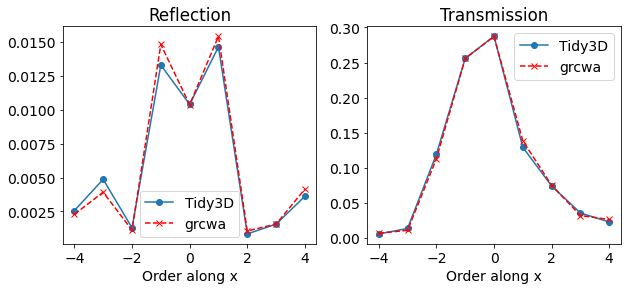

In [24]:
rc_orig = plt.rcParams['font.size']
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

orders_x = data_r.orders_x
ax[0].plot(orders_x, data_r.power.values[:,0], 'o-', label="Tidy3D")
ax[0].plot(orders_x, Ri_by_order[0], 'x--r', label="grcwa")
ax[0].set_title("Reflection")
ax[0].set_xlabel("Order along x")
ax[0].legend()

orders_x = data_t.orders_x
ax[1].plot(orders_x, data_t.power.values[:,0], 'o-', label="Tidy3D")
ax[1].plot(orders_x, Ti_by_order[0], 'x--r', label="grcwa")
ax[1].set_title("Transmission")
ax[1].set_xlabel("Order along x")
ax[1].legend()

plt.show()


## Plot and compare power amplitudes
Finally, we will compare the transmitted complex power amplitude for each order and each polarization to those obtained via the [grcwa](https://grcwa.readthedocs.io/en/latest/index.html) package.

Note that grcwa returns fields in Cartesian coordinates, while Tidy3D returns power amplitudes in the `s` and `p` polarization basis. Therefore, we will use some convenience methods to convert grcwa's fields to spherical coordinates before comparing the two solvers.

<Figure size 864x288 with 2 Axes>

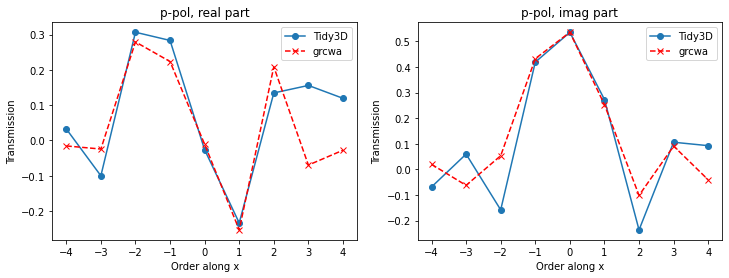

In [28]:
# get amplitudes from Tidy3D results
amps_sp = data_t.amps

# get amplitudes from grcwa

# we're sampling near-fields in the lower-most layer
layer = 4
# position above the simulation domain's bottom where we're sampling
z_offset = monitor_t.center[2] - (-sim_size[2]/2)
amps_grcwa_xy, _ = obj.Solve_FieldFourier(layer, z_offset)

# Extract grcwa results at orders corresponding to those computed by Tidy3D
amps_grcwa_xy = [np.array(
    rcwa_order_index(data_t.orders_x, data_t.orders_y, obj, amps)[1]
) for amps in amps_grcwa_xy]
# we need to swap the axes as below for the data to match
amps_grcwa_xy = [np.swapaxes(amps, 0, 1) for amps in amps_grcwa_xy]
# to match the format of Tidy3D data, add a fourth frequency dimension
amps_grcwa_xy = [amps[..., None] for amps in amps_grcwa_xy]

# to allow easily manipulating this data, we'll make a data array with grcwa results
# in the same format in which Tidy3D results are stored
coords = {}
coords["orders_x"] = np.atleast_1d(data_t.orders_x)
coords["orders_y"] = np.atleast_1d(data_t.orders_y)
coords["polarization"] = ["x", "y", "z"]
coords["f"] = np.array(data_t.frequencies)
amps_grcwa_car = td.DiffractionDataArray(
    np.stack(amps_grcwa_xy, axis=2), coords=coords
)

# since the data is now in Tidy3D-friendly format, we can use a convenience function to
# convert it to spherical coordinates
amps_grcwa_sp = data_t.car_2_sph(amps_grcwa_car)

# rename the polarization dimension to s and p from theta, phi
amps_grcwa_sp["polarization"] = ["p", "s"]

# finally, we can compare the complex amplitudes for the y=0 order, as a function of orders along x
pol = "p"
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
orders_x = data_t.orders_x
data_tidy3d = data_t.amps.sel(polarization=pol).values[:,0]
data_grcwa = amps_grcwa_sp.sel(polarization=pol).values[:,0]

ax[0].plot(orders_x, np.real(data_tidy3d), 'o-', label="Tidy3D")
ax[0].plot(orders_x, np.real(data_grcwa), 'x--r', label="grcwa")
ax[0].set_title(f"{pol}-pol, real part")
ax[0].set_ylabel("Transmission")
ax[0].set_xlabel("Order along x")
ax[0].legend()

ax[1].plot(orders_x, np.imag(data_tidy3d), 'o-', label="Tidy3D")
ax[1].plot(orders_x, np.imag(data_grcwa), 'x--r', label="grcwa")
ax[1].set_title(f"{pol}-pol, imag part")
ax[1].set_ylabel("Transmission")
ax[1].set_xlabel("Order along x")
ax[1].legend()

plt.show()

## Plot Field Distributions
Plot the frequency-domain electric field components at the center frequency along an `xz` cut of the domain.

<Figure size 1080x432 with 7 Axes>

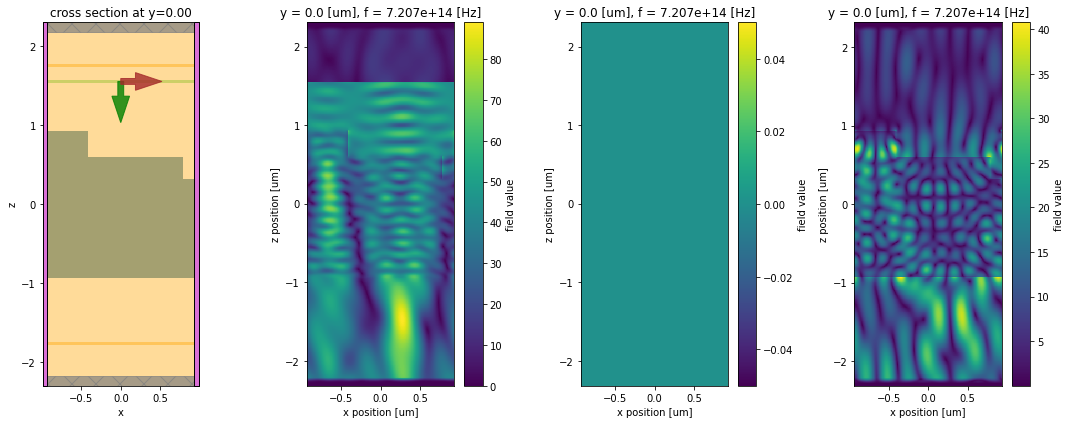

In [26]:
plt.rcParams.update({'font.size': rc_orig})

data = sim_data['field_xz']
fig, axs = plt.subplots(1, 4, tight_layout=True, figsize=(15, 6))
sim_data.simulation.plot(y=0, ax=axs[0]);
data.Ex.isel(y=0).abs.plot(x='x', y='z', ax=axs[1])
data.Ey.isel(y=0).abs.plot(x='x', y='z', ax=axs[2])
data.Ez.isel(y=0).abs.plot(x='x', y='z', ax=axs[3])
axs[1].set_aspect('equal')
axs[2].set_aspect('equal')
axs[3].set_aspect('equal')
plt.show()